In [17]:
import json
import torch
import os.path as osp

# Path to the JSON file
img_path = "/home/uig93971/src/data/street_obstacle_sequences/raw_data/sequence_015/000001_raw_data.jpg"
det_path = "/home/uig93971/src/data/street_obstacle_sequences/detections/sequence_015.json"

# Read the JSON file
with open(det_path, 'r') as file:
    detections = json.load(file)

In [18]:
%matplotlib inline

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np

def visualize_image(img_path, detections, known_score_threshold=0, unknown_score_threshold=0):
    
    # Load the image
    image = Image.open(img_path)

    # img = np.asarray(image)
    # imgplot = plt.imshow(img)

    # Your detection data
    detections_for_img = detections[osp.basename(img_path)]

    # Create a copy of the image to draw on
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image)

    # Font size and bounding box outline width
    font_size = 15          # Adjust this value for larger/smaller text
    outline_width = 3       # Adjust this value for thicker/thinner box outlines

    # Set font size for text annotations
    try:
        font = ImageFont.truetype("arial.ttf", font_size)  # Use specific font if available
    except IOError:
        font = ImageFont.load_default()             # Fallback to default font

    # Iterate through each detection
    k = 0
    for score, label, box in zip(detections_for_img['scores'], detections_for_img['labels'], detections_for_img['boxes']):
        if (score < known_score_threshold and label < 80) or (score < unknown_score_threshold and label == 80) or label == 81:
            continue  # Skip low-confidence boxes

        # Unpack box coordinates
        x1, y1, x2, y2 = box

        # Draw the bounding box
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

        # Create label text
        # print(label)
        text = f"Score: {score:.2f}"

        # Get text dimensions using textbbox
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Adjust text position to stay within image boundaries
        text_position = (x1, y1 - text_height if y1 - text_height > 0 else y1)

        # Draw a filled rectangle as a background for the text
        draw.rectangle(
            [text_position, (x1 + text_width, y1)],
            fill="red"
        )
        # Add text over the background
        draw.text(text_position, text, fill="white", font=font)

    draw_image.show()

    # Convert image to NumPy array for matplotlib compatibility
    # image_array = np.array(draw_image)

    # # Display the image with detections
    # plt.figure(figsize=(10, 10))
    # plt.imshow(image_array)
    # plt.axis("off")
    # plt.show()

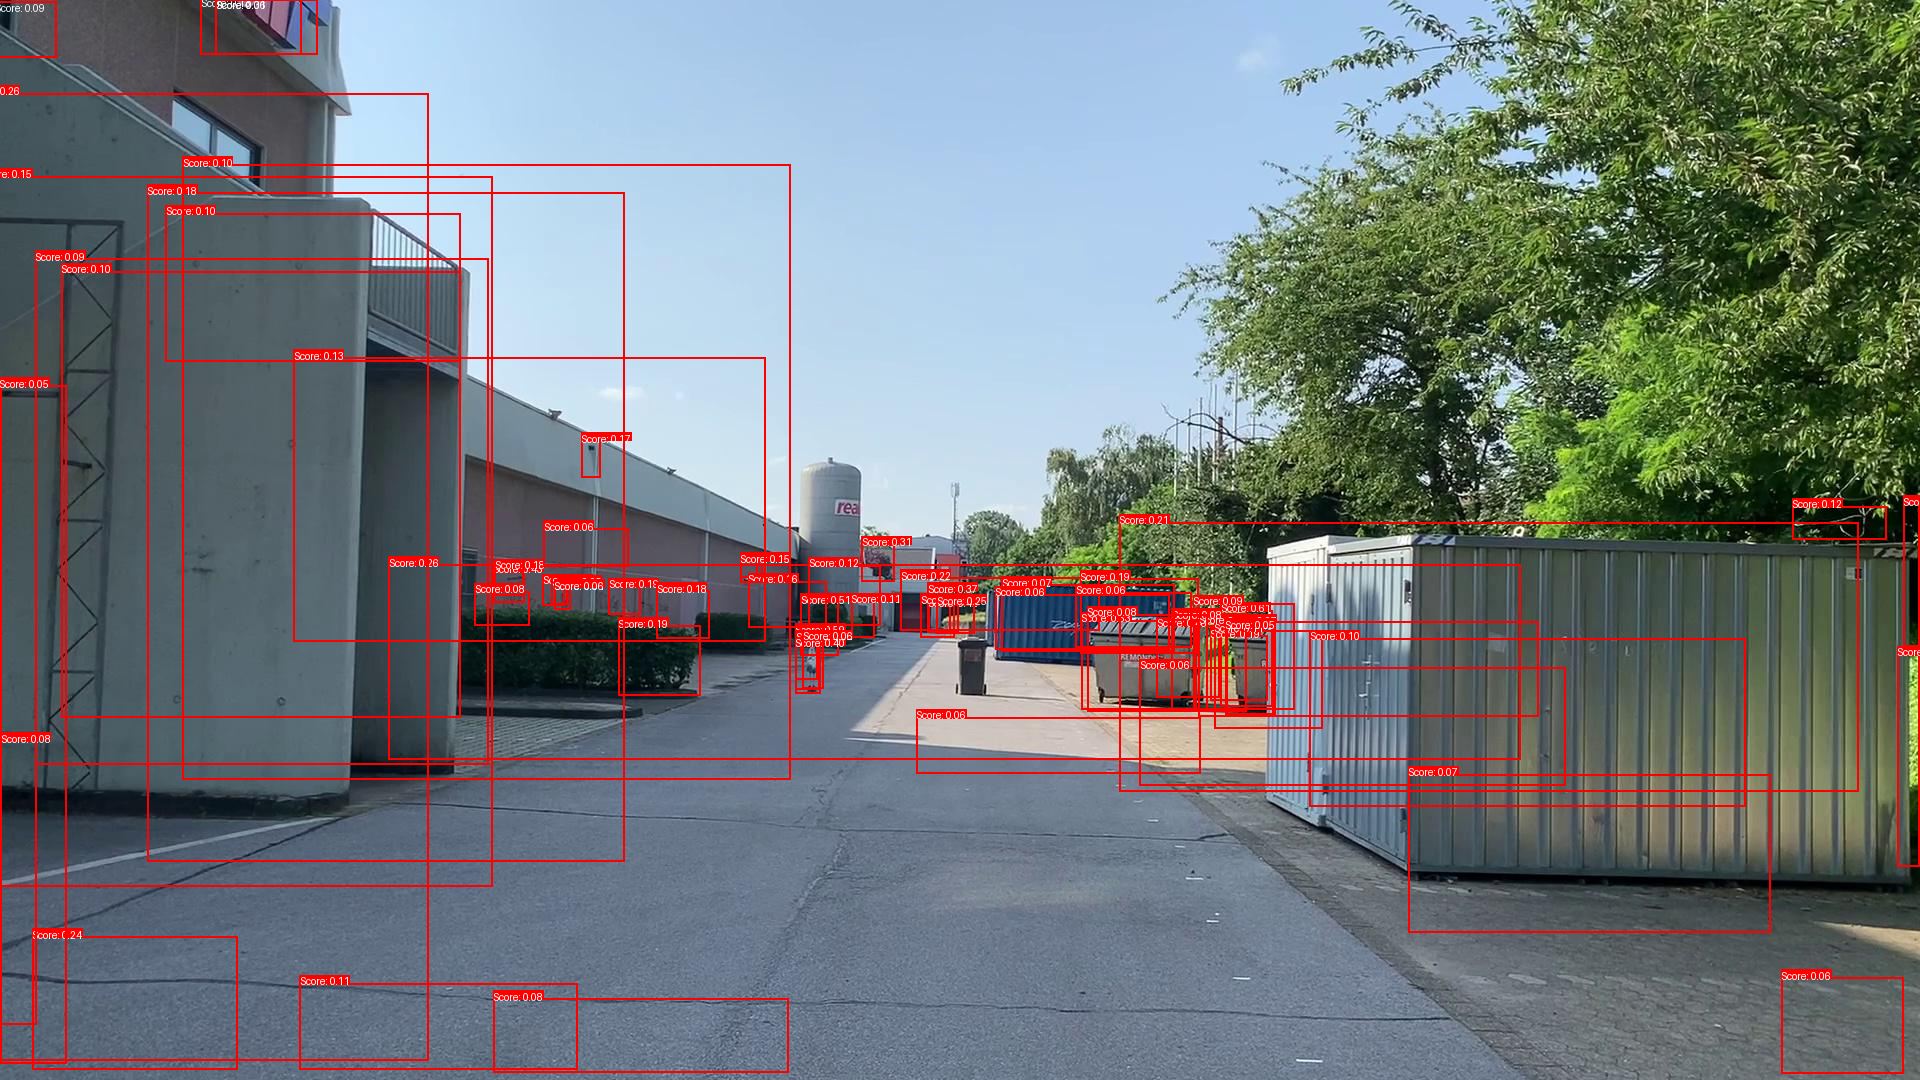

In [19]:
visualize_image(img_path, detections, known_score_threshold=0.0, unknown_score_threshold=0.0)

In [6]:
def unoverlap_masks(masks, scores):
    """
    Post-process segmentation masks to make them non-overlapping,
    giving priority to higher scoring masks.
    
    Args:
        masks (list of np.ndarray): List of binary segmentation masks (each of shape [H, W]).
        scores (np.ndarray): Array of scores corresponding to each mask.
        
    Returns:
        list of np.ndarray: List of updated, non-overlapping binary masks.
    """
    # Sort masks and scores by descending scores
    sorted_indices = np.argsort(scores.squeeze())[::-1]
    sorted_masks = [masks[i] for i in sorted_indices]
    
    # Create an empty canvas to track which pixels are already assigned
    occupied = np.zeros_like(sorted_masks[0], dtype=bool)
    
    # Create the list to store non-overlapping masks
    non_overlapping_masks = []
    
    for mask in sorted_masks:
        # Convert the mask to boolean to ensure compatibility
        mask = mask.astype(bool)
        
        # Remove overlaps by keeping only unoccupied areas
        non_overlapping_mask = mask & ~occupied
        non_overlapping_masks.append(non_overlapping_mask)
        
        # Update the occupied canvas
        occupied |= non_overlapping_mask  # Now works correctly since types match
    
    # Reorder masks to their original order
    reordered_masks = [non_overlapping_masks[i] for i in np.argsort(sorted_indices)]
    
    return reordered_masks

def preprocess_detections(detections, iou_threshold = 0.7, 
                          scale_for_known = 1, scale_for_unknown = 1):
    boxes_scores = [detections["boxes"][i] + [detections["scores"][i]] for i in range(len(detections["boxes"]))]
    boxes_scores_as_tensor = torch.tensor(boxes_scores, dtype=torch.float32, device='cpu')
    cls_as_tensor = torch.tensor(detections["labels"], dtype=torch.int64, device='cpu')
    unknown_class = 80
    keep_indices = custom_nms(boxes_scores_as_tensor[:, :4], boxes_scores_as_tensor[:, 4], cls_as_tensor, unknown_class, iou_threshold)
    final_det = []
    for i in range(len(detections["boxes"])):
        if i in keep_indices:
            new_score = detections["scores"][i]
            if detections["labels"][i] == unknown_class:
                new_score = min(1, new_score * scale_for_unknown)
            else:
                new_score = min(1, new_score * scale_for_known)
            final_det.append(detections["boxes"][i] + [new_score] + [detections["labels"][i]])
    final_det.sort(key=lambda x: x[-2], reverse=True)
    return np.array(final_det, dtype=np.float64)

from torchvision.ops.boxes import box_iou

def custom_nms(boxes, scores, labels, target_class, iou_threshold, high_iou_threshold=0.85):
    """
    Perform custom NMS where the target class is suppressed by all overlapping boxes.
    
    Args:
        boxes (Tensor): Tensor of shape (N, 4) with bounding box coordinates.
        scores (Tensor): Tensor of shape (N,) with confidence scores.
        labels (Tensor): Tensor of shape (N,) with class labels.
        target_class (int): The class to be suppressed by all overlaps.
        iou_threshold (float): IoU threshold for suppression.
        high_iou_threshold (float): IoU threshold for suppression of almost identical boxes regardless of class.
    Returns:
        keep_indices (Tensor): Indices of boxes to keep after suppression.
    """
    keep = torch.ones(len(boxes), dtype=torch.bool)  # Initialize keep mask

    # Compute pairwise IoU for all boxes
    iou_matrix = box_iou(boxes, boxes)

    for i in range(len(boxes)):
        if not keep[i]:
            continue  # Skip suppressed boxes
        
        # suppress_mask = (iou_matrix[i] > iou_threshold) & (scores[i] > scores) 
        # keep[suppress_mask] = False
        # Check if the current box is the target class
        if labels[i] == target_class:
            suppress_mask = (iou_matrix[i] > iou_threshold) & (labels == target_class) & (scores[i] > scores) 
            keep[suppress_mask] = False
        else:
            suppress_mask = ((iou_matrix[i] > iou_threshold) & (labels == labels[i]) & (scores[i] > scores)) | \
                            ((iou_matrix[i] > iou_threshold) & (labels == target_class) & (scores[i] > scores)) | \
                            ((iou_matrix[i] > high_iou_threshold) & (scores[i] > scores))
            keep[suppress_mask] = False

    return torch.where(keep)[0]  # Indices of boxes to keep


def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, score, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))
    if score is not None:
        ax.text(x0, y0, f'{score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5), fontsize=8, color='black')

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

60


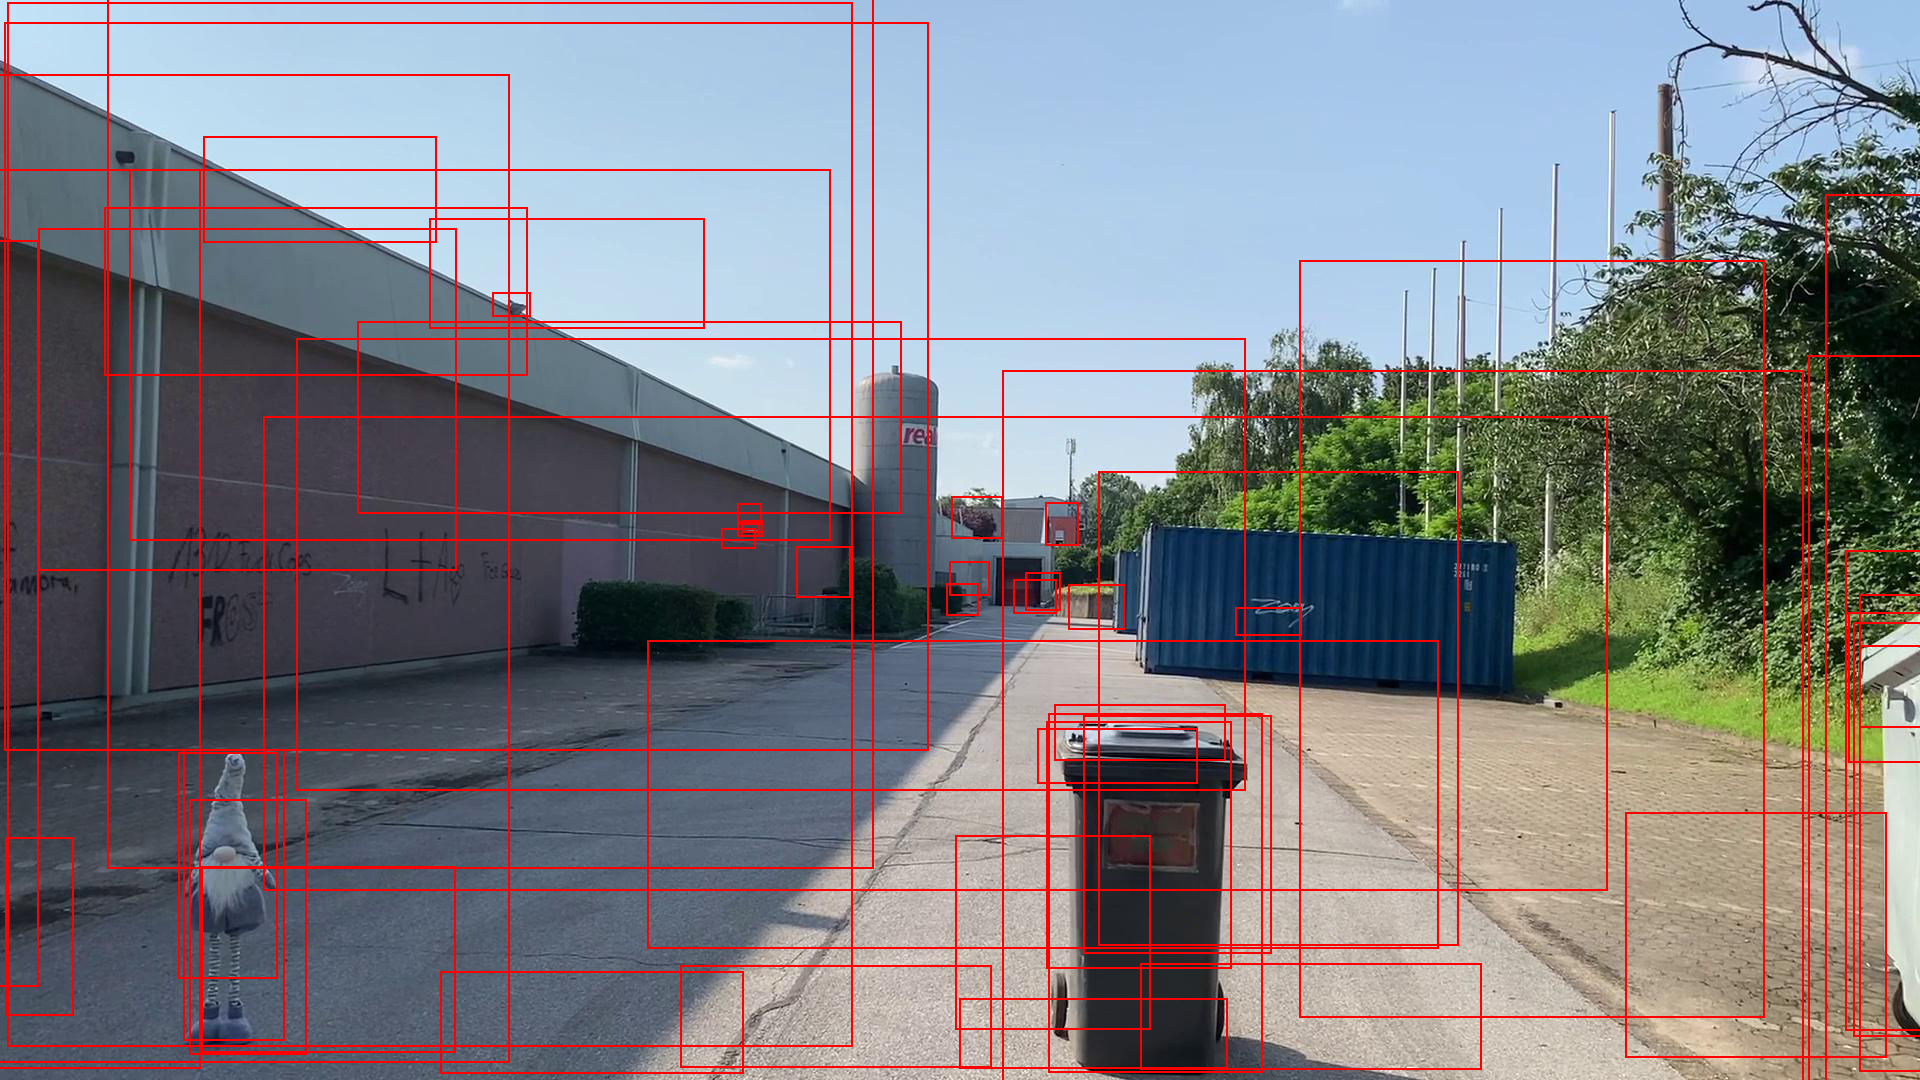

In [7]:
def visualize_boxes(img_path, detections, known_score_threshold=0, unknown_score_threshold=0):
    
    # Load the image
    image = Image.open(img_path)

    # Your detection data
    detections_for_img = detections
    print(len(detections_for_img))

    # Create a copy of the image to draw on
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image)

    # Iterate through each detection
    k = 0
    for i in range(len(detections_for_img)):

        # Unpack box coordinates
        x1, y1, x2, y2 = detections_for_img[i]

        # Draw the bounding box
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    draw_image.show()

outputs = preprocess_detections(detections[osp.basename(img_path)], iou_threshold=0.7, 
                                scale_for_known=1., scale_for_unknown=1.)

visualize_boxes(img_path, outputs[:, :4])

In [8]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


device = torch.device("cuda")
    
# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
        
# Model initialization
sam2_checkpoint = f"/home/uig93971/src/open-world-object-tracking/sam2/checkpoints/sam2.1_hiera_large.pt" # TODO add to arguments!
model_cfg = f"configs/sam2.1/sam2.1_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)
##############################

/home/uig93971/src/open-world-object-tracking/sam2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [9]:
image = Image.open(img_path)
w, h = image.size
image = np.array(image.convert("RGB"))
predictor.set_image(image)

objectness_threshold = 0.1
seg_threshold = 0.7

detections = detections[osp.basename(img_path)]
det_preproc = preprocess_detections(detections)
input_boxes = np.array([box for box in det_preproc if (box[-2] > 0.1) and (abs(box[0] - box[2]) < 0.4 * w) and (abs(box[1] - box[3]) < 0.7 * h)])[:, 0:-2]


masks, scores, low_res_m = predictor.predict(
    box=input_boxes,
    multimask_output=False,
)

masks = masks.squeeze()
scores = scores.squeeze()
filtered_masks = np.array(masks)[scores.squeeze() > seg_threshold]
filtered_scores = scores.squeeze()[scores.squeeze() > seg_threshold]

In [10]:
import numpy as np
from scipy.ndimage import distance_transform_edt

def find_centroid(mask):
    """
    Find the centroid (center of mass) of the segmentation mask.
    Ensures the chosen pixel is within the mask.
    """
    y_indices, x_indices = np.where(mask)
    centroid_x = int(np.mean(x_indices))
    centroid_y = int(np.mean(y_indices))
    
    # Check if the centroid is within the mask; if not, find the nearest valid pixel
    if not mask[centroid_y, centroid_x]:
        return find_nearest_valid_pixel(mask, (centroid_y, centroid_x))
    return centroid_x, centroid_y

def find_distance_transform_center(mask):
    """
    Find the center using a distance transform.
    Ensures the chosen pixel is within the mask.
    """
    distance = distance_transform_edt(mask)
    max_dist_idx = np.unravel_index(np.argmax(distance), mask.shape)
    return max_dist_idx  # This will always be inside the mask by definition

def find_nearest_valid_pixel(mask, point):
    """
    Find the nearest valid pixel in the mask to a given point.
    """
    distance = distance_transform_edt(mask == 0)  # Compute distance to non-mask regions
    nearest_idx = np.unravel_index(np.argmin(distance), mask.shape)
    return nearest_idx

def filter_masks(predictor, masks, scores, area_inc_threshold=2000):
    filtered_masks = []
    filtered_scores = []
    for mask, score in zip(masks, scores):
        ref_point = np.array(find_centroid(mask))
        refined_mask, _, _ = predictor.predict(
            point_coords=[ref_point],
            point_labels=np.array([1]),
            multimask_output=False,
        )
        refined_mask = refined_mask.squeeze()
        refined_area = np.sum(refined_mask)
        orig_area = np.sum(mask)
        # print(mask)
        intersection_area = np.sum(np.array(refined_mask, dtype=bool) & np.array(mask, dtype=bool))
        if not (intersection_area / orig_area > 0.8 and refined_area - orig_area > area_inc_threshold): 
            filtered_masks.append(mask)
            filtered_scores.append(score)
            
    return filtered_masks, filtered_scores

    

In [11]:
filtered_masks, filtered_scores = filter_masks(predictor, filtered_masks, filtered_scores)

/home/uig93971/src/open-world-object-tracking/sam2/sam2/sam2_image_predictor.py:314: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647327489/work/torch/csrc/utils/tensor_new.cpp:278.)
  point_coords = torch.as_tensor(


In [12]:
filtered_masks = unoverlap_masks(filtered_masks, np.array(filtered_scores))

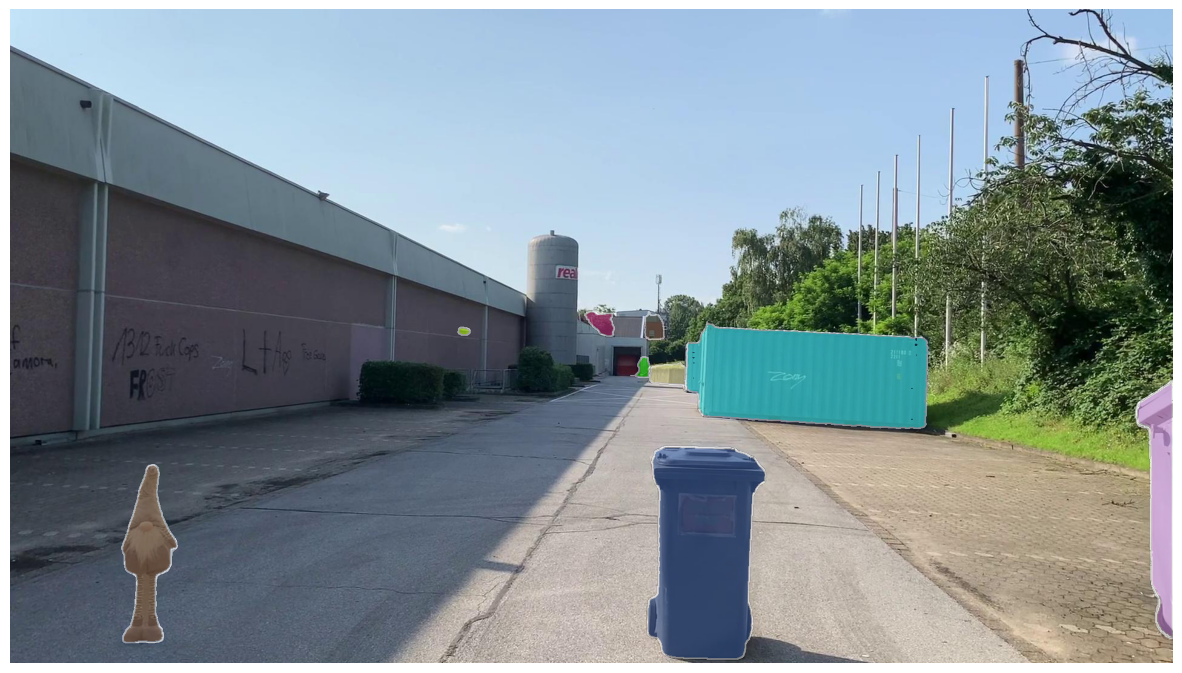

In [13]:
plt.figure(figsize=(15, 15))
plt.imshow(image)
for mask, score in zip(filtered_masks, filtered_scores):
    show_mask(mask, plt.gca(), random_color=True)
# for box, score in zip(input_boxes, scores):
#     show_box(box, *score, plt.gca())
plt.axis('off')
plt.show()

In [13]:
heatmap = np.sum(np.array(filtered_masks) * np.array(filtered_scores)[:, np.newaxis, np.newaxis], axis=0)

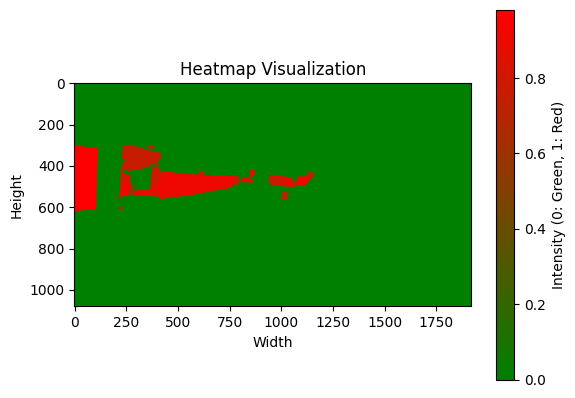

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Define a custom colormap from green to red
cmap = mcolors.LinearSegmentedColormap.from_list("GreenRed", ["green", "red"])

# Visualize the heatmap
plt.imshow(heatmap, cmap=cmap)
plt.colorbar(label="Intensity (0: Green, 1: Red)")
plt.title("Heatmap Visualization")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

In [15]:
def show_mask_orig(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks_orig(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask_orig(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [16]:
input_point = np.array([[1000, 800]])
input_label = np.array([1])

road_masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

scores

array([0.9765625], dtype=float32)

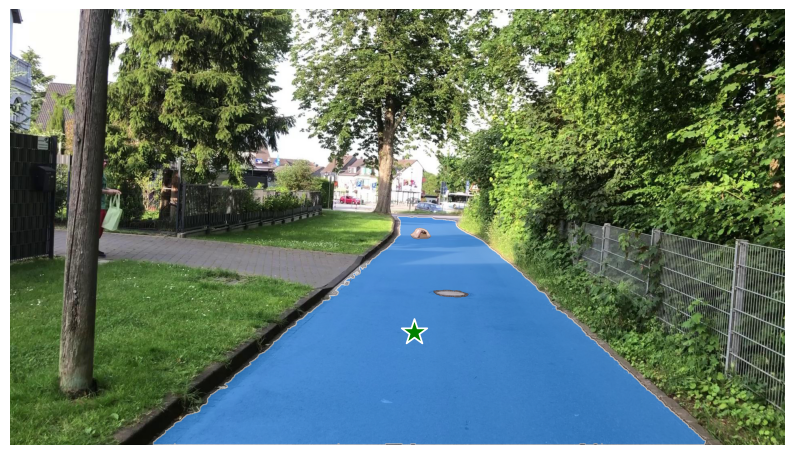

In [17]:
show_masks_orig(image, road_masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

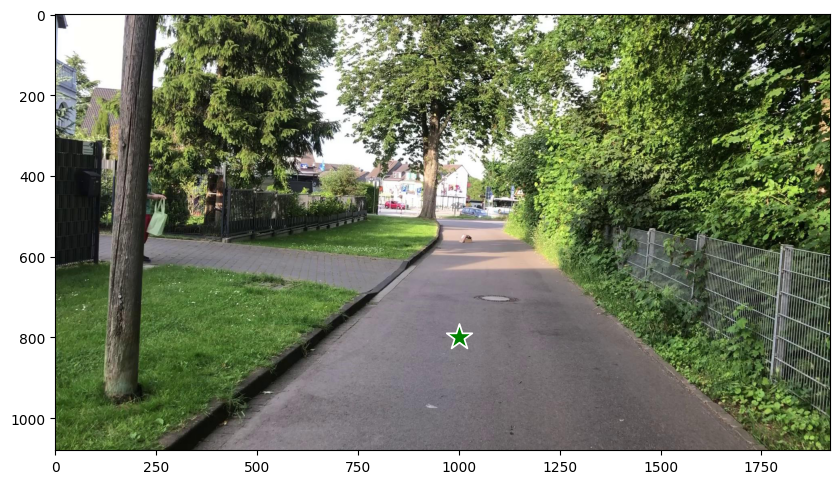

array([[1000,  800]])

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()
input_point